In [1]:
import chess, random, time
import pandas as pd
from anytree import Node, RenderTree
from AIGame import AIGame

In [2]:
def game_outcome(board):
    # If it's black's turn (white won) return 1, if it's white turn return -1
    if board.is_checkmate():
        outcome = (board.turn*-2)+1
    # If it's a draw return 0
    elif board.can_claim_draw() or board.is_stalemate() or board.is_insufficient_material():
        outcome = 0
    return outcome

def random_AI_games(n):
    game_tally = []
    score = 0
    ai_time = []
    move_time = []
    for i in range(n):
        board = chess.Board()
        while not board.is_game_over(claim_draw=True):
            t1 = time.time()
            AImove = random.choice(list(board.legal_moves))
            t2 = time.time()
            ai_time.append(t2-t1)
            board.push(AImove)
            t3 = time.time()
            move_time.append(t3-t2)
        game_tally.append(board.outcome())
        score += game_outcome(board)

    return game_tally, score, ai_time, move_time

In [37]:
game_tally, score, ai_time, move_time = random_AI_games(10)
print(score)
pd.Series(game_tally).value_counts()
#board.move_stack

-1


Outcome(termination=<Termination.INSUFFICIENT_MATERIAL: 3>, winner=None)    45
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)                 6
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)                5
Outcome(termination=<Termination.STALEMATE: 2>, winner=None)                 3
Name: count, dtype: int64

In [38]:
# print(pd.Series(ai_time).mean(), pd.Series(ai_time).std(), pd.Series(ai_time).sum())
# print(pd.Series(move_time).mean(), pd.Series(move_time).std(), pd.Series(move_time).sum())

9.080226217080038e-05 5.9545848439306014e-05 3.1443915367126465
1.5075746053923543e-05 1.165188806667499e-05 0.5220580101013184


# Eval

In [8]:
piece_names = {1:'pawn', 2:'knight', 3:'bishop', 4:'rook', 5:'queen', 6:'king'}
piece_value = {1:1, 2:2.9, 3:3.1, 4:5, 5:9, 6:0, None:0}
pieces = [1, 2, 3, 4, 5]

In [18]:
def board_value(board):
    white_value, black_value = 0, 0
    for piece in pieces:
        white_value += piece_value[piece]*len(board.pieces(piece,True))
        black_value += piece_value[piece]*len(board.pieces(piece,False))

    return round(white_value+black_value,2), white_value, black_value

def number_of_piece_type_at_squares(board, piece_type, squares, color):
    return len([x for x in board.pieces(piece_type,color) if x in squares])

In [19]:
board = chess.Board('r4knr/ppp2ppp/2Q5/8/8/1Pq4P/P1P2P1P/R1BK1B1R b - - 1 11') # Mid
board = chess.Board('5knr/p1p2ppp/8/1r6/8/7P/P1P2P1P/R1BK2R1 w - - 0 16') # Late

print(board_value(board))

(36.0, 18.1, 17.9)


In [20]:
def evaluate_board(board):
    total_value, white_value, black_value = board_value(board) # First get the board piece values for white and black
    eval = white_value - black_value # The eval is positive if white is winning, negative if black is winning

    # Kings should be hidden behind pawns in early and middle game
    if total_value > 40:
        if board.king(1) in [0,1,2]:
            eval += 0.5 + 0.25 * len([x for x in board.pieces(1,1) if x in [0,1,2]])
        if board.king(1) in [6,7]:
            eval += 0.5 + 0.25 * len([x for x in board.pieces(1,1) if x in [5,6,7]])

        if board.king(0) in [56,57,58]:
            eval += -0.5 - 0.25 * len([x for x in board.pieces(1,0) if x in [48,49,50]])
        if board.king(0) in [62,63]:
            eval += -0.5 - 0.25 * len([x for x in board.pieces(1,1) if x in [53,54,55]])

        # Control of the center in early-middle game - but not rooks or queen
        four_central_squares = [27, 28, 35, 36]
        sixteen_central_squares = [18,19,20,21,26,29,34,37,42,43,44,45]
        for piece_type in [1,2,3]:
            for color in [0,1]: # 0 is black, 1 is white
                eval += (color*2-1) * (0.5 * number_of_piece_type_at_squares(board, piece_type, four_central_squares, color))
                eval += (color*2-1) * (0.25 * number_of_piece_type_at_squares(board, piece_type, sixteen_central_squares, color))

    if total_value >= 60:
        pass # Early game
    if total_value <= 40:
        pass # Late game
    else:
        pass # Mid game

    return eval

equal material, white castled 0.7000000000000028


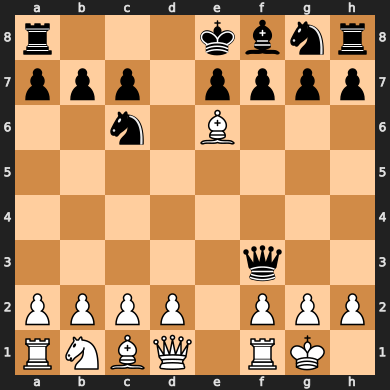

In [21]:
board = chess.Board('r3kbnr/ppp1pppp/2n1B3/8/8/5q2/PPPP1PPP/RNBQ1RK1 b kq - 2 6')
print('equal material, white castled', evaluate_board(board))
board

In [22]:
board = chess.Board('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0') 
print('e4 moved', evaluate_board(board))

board = chess.Board('rnbqkbnr/ppp1pppp/8/3P4/8/8/PPPP1PPP/RNBQKBNR b KQkq - 0 2') 
print('black pawn down', evaluate_board(board))

board = chess.Board('rnb1kbnr/ppp1pppp/8/8/2B5/5q2/PPPP1PPP/RNBQK2R b KQkq - 1 4')
print('white knight down', evaluate_board(board))

board = chess.Board('r3kbnr/ppp1pppp/2n1B3/8/8/5q2/PPPP1PPP/RNBQ1RK1 b kq - 2 6')
print('equal material, white castled', evaluate_board(board))

e4 moved 0.5
black pawn down 1.5
white knight down -2.6499999999999986
equal material, white castled 0.7000000000000028


In [36]:
board = chess.Board('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0') 
times = []

for i in range(400000):
    t1 = time.time()
    evaluate_board(board)
    t2 = time.time()
    times.append(t2-t1)

sum(times)

36.741573333740234

# Depth search

In [19]:
# Depth 1 search

board = chess.Board()

moves_checked = []
current_move_eval = []
best_moves = {}

for move1 in list(board.legal_moves):
    current_move_eval.append(board.san(move1)) # Save which move we are looking at
    board.push(move1) # Make the move
    current_move_eval.append(evaluate_board(board)) # Save the evaluation since we are at a leaf node
    
    moves_checked.append(current_move_eval[:]) # Track all the moves we looked at using a deep copy
    
    board.pop() # Undo the last move
    current_move_eval = [] # Reset the current move we are looking at

moves_checked_df = pd.DataFrame(moves_checked)
moves_checked_df.loc[moves_checked_df.iloc[:,1] == max(moves_checked_df.iloc[:,1])]


,0,1
3,Na3,0.92944


In [111]:
# Depth 2 search

board = chess.Board()
board = chess.Board('r1bqkbnr/pppp1ppp/2n5/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 3 3')

player = 1
player_turn = [player*1, player*-1, player*1, player*-1] # Which players turn it is
depth1_search = []
depth2_search = []
current_move_eval = []

for move1 in list(board.legal_moves):
    current_move_eval.append(board.san(move1))
    board.push(move1) # Make the move

    for move2 in list(board.legal_moves):
        current_move_eval.append(board.san(move2)) # Save which move we are looking at
        board.push(move2) # Make the move
        current_move_eval.append(evaluate_board(board)) # Save the evaluation since we are at a leaf node
        
        depth2_search.append(current_move_eval[:]) # Track all the moves we looked at in this depth
        
        board.pop() # Undo the last move
        del current_move_eval[-2:] # Remove the last move and eval

    best_move2 = max(depth2_search, key=lambda x: player_turn[1]*x[2])
    depth1_search.append(best_move2)

    depth2_search = []
    board.pop()
    current_move_eval.pop()

best_move1 = max(depth1_search, key=lambda x: player_turn[0]*x[2])



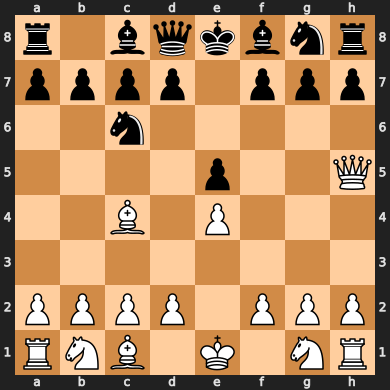

In [48]:
board = chess.Board('r1bqkbnr/pppp1ppp/2n5/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 3 3')
board

In [187]:
def depth3_Search(board):
    player = board.turn*2-1
    player_turn = [player*1, player*-1, player*1, player*-1] # Which players turn it is
    depth1_search = []
    depth2_search = []
    depth3_search = []
    current_move_eval = []
    all_moves = []

    for move1 in list(board.legal_moves):
        current_move_eval.append(board.san(move1))
        board.push(move1) # Make the move
        if board.is_game_over(claim_draw=True): # Check if the move meant the game was finished
            outcome = game_outcome(board)
            print(outcome)
            mate_moves = current_move_eval[:]
            mate_moves.extend(['','',outcome*999])
            depth1_search.append(mate_moves)
            mate_moves = []

        else:
            for move2 in list(board.legal_moves):
                current_move_eval.append(board.san(move2)) # Save which move we are looking at
                board.push(move2) # Make the move
                if board.is_game_over(claim_draw=True): # Check if the move meant the game was finished
                    outcome = game_outcome(board)
                    mate_moves = current_move_eval[:]
                    mate_moves.extend(['',outcome*999])
                    depth2_search.append(mate_moves)
                    mate_moves = []

                else: # If the move wasn't an ending one, check for the best next move
                    for move3 in list(board.legal_moves):
                        current_move_eval.append(board.san(move3)) # Save which move we are looking at
                        board.push(move3) # Make the move
                        
                        eval = evaluate_board(board)
                        current_move_eval.append(eval) # Save the evaluation since we are at a leaf node
                        depth3_search.append(current_move_eval[:]) # Track all the moves we looked at in this depth
                        all_moves.append(current_move_eval[:])
                        
                        board.pop() # Undo the last move
                        del current_move_eval[-2:] # Remove the last move and eval

                    best_move3 = max(depth3_search, key=lambda x: player_turn[2]*x[3])
                    depth2_search.append(best_move3)

                depth3_search = []
                board.pop()
                current_move_eval.pop()

            best_move2 = max(depth2_search, key=lambda x: player_turn[1]*x[3])
            depth1_search.append(best_move2)

        depth2_search = []
        board.pop()
        current_move_eval.pop()

    return max(depth1_search, key=lambda x: player_turn[0]*x[3])

def depth3_Search_prune(board):
    player = board.turn*2-1
    player_turn = [player*1, player*-1, player*1, player*-1] # Which players turn it is
    depth1_search = []
    depth2_search = []
    depth3_search = []
    current_move_eval = []
    all_moves = []

    depth1_bestmove = -player_turn[0]*999 # White wants the biggest eval so start at -999
    depth2_bestmove = -player_turn[1]*999

    for move1 in list(board.legal_moves):
        current_move_eval.append(board.san(move1))
        board.push(move1) # Make the move
        if board.is_game_over(claim_draw=True): # Check if the move meant the game was finished
            outcome = game_outcome(board)
            print(outcome)
            mate_moves = current_move_eval[:]
            mate_moves.extend(['','',outcome*999])
            depth1_search.append(mate_moves)
            mate_moves = []

        else:
            for move2 in list(board.legal_moves):
                current_move_eval.append(board.san(move2)) # Save which move we are looking at
                board.push(move2) # Make the move
                if board.is_game_over(claim_draw=True): # Check if the move meant the game was finished
                    outcome = game_outcome(board)
                    mate_moves = current_move_eval[:]
                    mate_moves.extend(['',outcome*999])
                    depth2_search.append(mate_moves)
                    mate_moves = []

                else: # If the move wasn't an ending one, check for the best next move
                    for move3 in list(board.legal_moves):
                        current_move_eval.append(board.san(move3)) # Save which move we are looking at
                        board.push(move3) # Make the move
                        
                        eval = evaluate_board(board)
                        current_move_eval.append(eval) # Save the evaluation since we are at a leaf node
                        depth3_search.append(current_move_eval[:]) # Track all the moves we looked at in this depth
                        all_moves.append(current_move_eval[:])
                        
                        board.pop() # Undo the last move
                        del current_move_eval[-2:] # Remove the last move and eval

                        #print(player_turn[1]*eval < player_turn[1]*depth2_bestmove)
                        if player_turn[1]*eval < player_turn[1]*depth2_bestmove: # No need to explore moves further as the the next player won't choose a worse move
                            break

                    best_move3 = max(depth3_search, key=lambda x: player_turn[2]*x[3])
                    depth2_bestmove = player_turn[1]*max(player_turn[1]*best_move3[-1], player_turn[1]*depth2_bestmove)
                    depth2_search.append(best_move3)

                depth3_search = []
                board.pop()
                current_move_eval.pop()
                #print(player_turn[0]*best_move3[-1], player_turn[0]*depth1_bestmove)
                if player_turn[0]*best_move3[-1] < player_turn[0]*depth1_bestmove:
                        #print('break')
                        break

            best_move2 = max(depth2_search, key=lambda x: player_turn[1]*x[3])
            depth1_bestmove = player_turn[0]*max(player_turn[0]*best_move2[-1], player_turn[0]*depth2_bestmove)
            depth1_search.append(best_move2)
            depth2_bestmove = -player_turn[1]*999

        depth2_search = []
        board.pop()
        current_move_eval.pop()

    return max(depth1_search, key=lambda x: player_turn[0]*x[3])

In [188]:
# Depth 3 search no pruning

#board = chess.Board()
#board.push_san("e4")
board = chess.Board('r1bqkbnr/pppp1ppp/2n5/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 3 3')
board.push_san("g6")

player = board.turn*2-1
player_turn = [player*1, player*-1, player*1, player*-1] # Which players turn it is
depth1_search = []
depth2_search = []
depth3_search = []
current_move_eval = []
all_moves = []

depth2_bestmove = -player_turn[1]*999 # White wants the biggest eval so start at -999

for move1 in list(board.legal_moves):
    current_move_eval.append(board.san(move1))
    board.push(move1) # Make the move
    if board.is_game_over(claim_draw=True): # Check if the move meant the game was finished
        outcome = game_outcome(board)
        print(outcome)
        mate_moves = current_move_eval[:]
        mate_moves.extend(['','',outcome*999])
        depth1_search.append(mate_moves)
        mate_moves = []

    else:
        for move2 in list(board.legal_moves):
            current_move_eval.append(board.san(move2)) # Save which move we are looking at
            board.push(move2) # Make the move
            if board.is_game_over(claim_draw=True): # Check if the move meant the game was finished
                outcome = game_outcome(board)
                mate_moves = current_move_eval[:]
                mate_moves.extend(['',outcome*999])
                depth2_search.append(mate_moves)
                mate_moves = []

            else: # If the move wasn't an ending one, check for the best next move
                for move3 in list(board.legal_moves):
                    current_move_eval.append(board.san(move3)) # Save which move we are looking at
                    board.push(move3) # Make the move
                    
                    eval = evaluate_board(board)
                    current_move_eval.append(eval) # Save the evaluation since we are at a leaf node
                    depth3_search.append(current_move_eval[:]) # Track all the moves we looked at in this depth
                    all_moves.append(current_move_eval[:])
                    
                    board.pop() # Undo the last move
                    del current_move_eval[-2:] # Remove the last move and eval

                best_move3 = max(depth3_search, key=lambda x: player_turn[2]*x[3])
                depth2_search.append(best_move3)

            depth3_search = []
            board.pop()
            current_move_eval.pop()

        best_move2 = max(depth2_search, key=lambda x: player_turn[1]*x[3])
        depth1_search.append(best_move2)

    depth2_search = []
    board.pop()
    current_move_eval.pop()

best_move1 = max(depth1_search, key=lambda x: player_turn[0]*x[3])



In [189]:
# Depth 3 search

#board = chess.Board()
#board.push_san("e4")
board = chess.Board('r4knr/ppp2ppp/2Q5/8/8/1Pq4P/P1P2P1P/R1BK1B1R b - - 1 11')
board.push_san("g6")

player = board.turn*2-1
player_turn = [player*1, player*-1, player*1, player*-1] # Which players turn it is
depth1_search = []
depth2_search = []
depth3_search = []
current_move_eval = []
all_moves = []

depth1_bestmove = -player_turn[0]*999 # White wants the biggest eval so start at -999
depth2_bestmove = -player_turn[1]*999

for move1 in list(board.legal_moves):
    current_move_eval.append(board.san(move1))
    board.push(move1) # Make the move
    if board.is_game_over(claim_draw=True): # Check if the move meant the game was finished
        outcome = game_outcome(board)
        print(outcome)
        mate_moves = current_move_eval[:]
        mate_moves.extend(['','',outcome*999])
        depth1_search.append(mate_moves)
        mate_moves = []

    else:
        for move2 in list(board.legal_moves):
            current_move_eval.append(board.san(move2)) # Save which move we are looking at
            board.push(move2) # Make the move
            if board.is_game_over(claim_draw=True): # Check if the move meant the game was finished
                outcome = game_outcome(board)
                mate_moves = current_move_eval[:]
                mate_moves.extend(['',outcome*999])
                depth2_search.append(mate_moves)
                mate_moves = []

            else: # If the move wasn't an ending one, check for the best next move
                for move3 in list(board.legal_moves):
                    current_move_eval.append(board.san(move3)) # Save which move we are looking at
                    board.push(move3) # Make the move
                    
                    eval = evaluate_board(board)
                    current_move_eval.append(eval) # Save the evaluation since we are at a leaf node
                    depth3_search.append(current_move_eval[:]) # Track all the moves we looked at in this depth
                    all_moves.append(current_move_eval[:])
                    
                    board.pop() # Undo the last move
                    del current_move_eval[-2:] # Remove the last move and eval

                    #print(player_turn[1]*eval < player_turn[1]*depth2_bestmove)
                    if player_turn[1]*eval < player_turn[1]*depth2_bestmove: # No need to explore moves further as the the next player won't choose a worse move
                        break

                best_move3 = max(depth3_search, key=lambda x: player_turn[2]*x[3])
                depth2_bestmove = player_turn[1]*max(player_turn[1]*best_move3[-1], player_turn[1]*depth2_bestmove)
                depth2_search.append(best_move3)

            depth3_search = []
            board.pop()
            current_move_eval.pop()
            #print(player_turn[0]*best_move3[-1], player_turn[0]*depth1_bestmove)
            if player_turn[0]*best_move3[-1] < player_turn[0]*depth1_bestmove:
                    #print('break')
                    break

        best_move2 = max(depth2_search, key=lambda x: player_turn[1]*x[3])
        depth1_bestmove = player_turn[0]*max(player_turn[0]*best_move2[-1], player_turn[0]*depth2_bestmove)
        depth1_search.append(best_move2)
        depth2_bestmove = -player_turn[1]*999

    depth2_search = []
    board.pop()
    current_move_eval.pop()

best_move1 = max(depth1_search, key=lambda x: player_turn[0]*x[3])
depth1_bestmove = -player_turn[0]*999



In [197]:
t1 = time.time()
# board = chess.Board('r3kbnr/ppp1pppp/2n1B3/8/8/5q2/PPPP1PPP/RNBQ1RK1 b kq - 2 6')
# board = chess.Board('r4knr/ppp2ppp/2Q5/8/8/1Pq4P/P1P2P1P/R1BK1B1R b - - 1 11') # Mid
# board = chess.Board('5knr/p1p2ppp/8/1r6/8/7P/P1P2P1P/R1BK2R1 w - - 0 16') # Late
#board = chess.Board('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0') 
#board = chess.Board('rnbqkbnr/ppp1pppp/8/3P4/8/8/PPPP1PPP/RNBQKBNR b KQkq - 0 2') 
#board = chess.Board('rnb1kbnr/ppp1pppp/8/8/2B5/5q2/PPPP1PPP/RNBQK2R b KQkq - 1 4')
#board = chess.Board('r3kbnr/ppp1pppp/2n1B3/8/8/5q2/PPPP1PPP/RNBQ1RK1 b kq - 2 6')


print(depth3_Search(board))
t2 = time.time()
print(t2 - t1)
print(depth3_Search_prune(board))
print(time.time() - t2)

['Qxd1', 'Rxd1', 'fxe6', -2.8999999999999986]
7.56864857673645
['Qxd1', 'Rxd1', 'fxe6', -2.8999999999999986]
3.2223639488220215


In [184]:
print(len(all_moves))

9640


In [185]:
best_move1

['Qxc3', 'Rd8+', 'Bd3', 12.55]

In [174]:
#all_moves

In [175]:
#all_moves

In [64]:
depth3_search

[]

In [97]:
depth2_search

[]

In [123]:
depth1_search

[['Nge7', 'Qxf7#', '', 999],
 ['Nh6', 'Bd5', 'Bd6', 0.0],
 ['Nf6', 'Qxf7#', '', 999],
 ['Be7', 'Qxf7#', '', 999],
 ['Bd6', 'Qxf7#', '', 999],
 ['Bc5', 'Qxf7#', '', 999],
 ['Bb4', 'Qxf7#', '', 999],
 ['Ba3', 'Qxf7#', '', 999],
 ['Ke7', 'Qxf7+', 'Kd6', 1.0],
 ['Qe7', 'Bd5', 'Nf6', 0.0],
 ['Qf6', 'Bd5', 'Qxf2+', -0.75],
 ['Qg5', 'Qxg5', 'd5', 8.5],
 ['Qh4', 'Qxh4', 'd5', 8.5],
 ['Rb8', 'Qxf7#', '', 999],
 ['Nb8', 'Qxf7#', '', 999],
 ['Nce7', 'Qxf7#', '', 999],
 ['Na5', 'Qxf7#', '', 999],
 ['Nd4', 'Qxf7#', '', 999],
 ['Nb4', 'Qxf7#', '', 999],
 ['h6', 'Qxf7#', '', 999],
 ['g6', 'Qg4', 'd5', -0.5],
 ['d6', 'Qxf7#', '', 999],
 ['b6', 'Qxf7#', '', 999],
 ['a6', 'Qxf7#', '', 999],
 ['g5', 'Qxf7#', '', 999],
 ['d5', 'exd5', 'Qxd5', -0.5],
 ['b5', 'Qxf7#', '', 999],
 ['a5', 'Qxf7#', '', 999]]

In [34]:
# Depth 4 search

# board = chess.Board()
# board.push_san("e4")
board = chess.Board('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0')

player = board.turn*2-1 # 1 for white, -1 for black
player_turn = [player*1, player*-1, player*1, player*-1] # Which players turn it is
depth1_search = []
depth2_search = []
depth3_search = []
depth4_search = []
current_move_eval = []
all_moves = []

for move1 in list(board.legal_moves):
    current_move_eval.append(board.san(move1))
    board.push(move1) 

    for move2 in list(board.legal_moves):
        current_move_eval.append(board.san(move2)) 
        board.push(move2) 

        for move3 in list(board.legal_moves):
            current_move_eval.append(board.san(move3))
            board.push(move3)

            for move4 in list(board.legal_moves):
                current_move_eval.append(board.san(move4))
                board.push(move4)
            
                current_move_eval.append(evaluate_board(board))
                depth4_search.append(current_move_eval[:])
                all_moves.append(current_move_eval[:])
            
                board.pop() # Undo the last move
                del current_move_eval[-2:] # Remove the last move and eval
                    
            best_move4 = max(depth4_search, key=lambda x: player_turn[3]*x[4])
            depth3_search.append(best_move4)

            depth4_search = []
            board.pop()
            current_move_eval.pop()

        best_move3 = max(depth3_search, key=lambda x: player_turn[2]*x[4])
        depth2_search.append(best_move3)

        depth3_search = []
        board.pop()
        current_move_eval.pop()

    best_move2 = max(depth2_search, key=lambda x: player_turn[1]*x[4])
    depth1_search.append(best_move2)

    depth2_search = []
    board.pop()
    current_move_eval.pop()

best_move1 = max(depth1_search, key=lambda x: player_turn[0]*x[4])


In [35]:
print(len(all_moves))
best_move1

405385


['Nc6', 'Bb5', 'Ne5', 'Bxd7+', 1.0]

In [180]:
board = chess.Board()

moves_checked = []
move_eval = []
best_moves = {}

def recurse(move, board, move_eval, depth):
    move_eval.append(board.san(move))
    board.push(move)
    if depth != 0:
        for next_move in list(board.legal_moves):
            recurse(next_move, board, move_eval, depth-1)
            board.pop()
            move_eval.pop()
    else:
        move_eval.append(evaluate_board(board))
        move_eval2 = move_eval[:] # Create a copy to avoid the moves checked changing
        moves_checked.append(move_eval2)
        move_eval.pop()
    
    

for move in list(board.legal_moves):
    recurse(move, board, move_eval, 1)
    move_eval.pop()
    board.pop()

In [181]:
depth = 2
d = {}
main_move = 'e9'
for i in range(len(moves_checked)):
    for j in range(depth):
        if j == 0:
            d[moves_checked[i][j]] = main_move
        elif j == depth-1:
            d[moves_checked[i][j] + ': ' + str(moves_checked[i][j+1])] = moves_checked[i][j-1]
        else:
            d[moves_checked[i][j]] = moves_checked[i][j-1]

In [183]:
print(len(moves_checked))
nodes = {}
for k, v in d.items():
    nk = nodes[k] = nodes.get(k) or Node(k)
    nv = nodes[v] = nodes.get(v) or Node(v)
    nk.parent = nv

root = nodes[main_move]
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))


# moves_checked

400
e9
├── Nh3
│   ├── Nh6: 0.6806470615336879
│   ├── Nf6: 0.6217839986787556
│   ├── Nc6: 0.2852121003205479
│   ├── Na6: 0.26139840177349605
│   ├── h6: 0.7440787951460813
│   ├── g6: 0.5173009254637299
│   ├── f6: 0.5231993369974601
│   ├── e6: 0.496237178879382
│   ├── d6: 0.0312876835806688
│   ├── c6: 0.8302190971366599
│   ├── b6: 0.10771120645005927
│   ├── a6: 0.05630750047403488
│   ├── h5: 0.30976507273530784
│   ├── g5: 0.8277531877233895
│   ├── f5: 0.24400142570358452
│   ├── e5: 0.9419038605166407
│   ├── d5: 0.8381058886332238
│   ├── c5: 0.8556898171168633
│   ├── b5: 0.01609379648802234
│   └── a5: 0.0870021132392037
├── Nf3
│   ├── Nh6: 0.7608510182665024
│   ├── Nf6: 0.6724155992924392
│   ├── Nc6: 0.7958952958781799
│   ├── Na6: 0.989209502262018
│   ├── h6: 0.002848696604305645
│   ├── g6: 0.5647190414730378
│   ├── f6: 0.46480019479713996
│   ├── e6: 0.7169253506764109
│   ├── d6: 0.48510331177052324
│   ├── c6: 0.8870802283098966
│   ├── b6: 0.9283430889378709


In [138]:
board = chess.Board()
board.push_san("e4")

moves_checked = [] # All the moves that were evaluated
move_eval = [] # The current move set being evaluated

for move in list(board.legal_moves):
    move_eval.append(str(move))
    board.push(move)
    # All the legal moves after making 1 move
    for move2 in list(board.legal_moves):
        move_eval.append(str(move2))
        board.push(move2)
        move_eval.append(evaluate_board(board))
        move_eval2 = move_eval[:] # Create a copy to avoid the moves checked changing
        moves_checked.append(move_eval2)
        move_eval.pop()
        move_eval.pop()
        board.pop()
    board.pop()
    move_eval.pop()


In [139]:
print(len(moves_checked))
moves_checked

600


[['g8h6', 'g1h3', 0.9461665678208621],
 ['g8h6', 'g1f3', 0.23938419346454765],
 ['g8h6', 'g1e2', 0.6612608907621956],
 ['g8h6', 'f1a6', 0.21816494759896587],
 ['g8h6', 'f1b5', 0.7931543975672238],
 ['g8h6', 'f1c4', 0.9565207670625432],
 ['g8h6', 'f1d3', 0.9620751942716619],
 ['g8h6', 'f1e2', 0.5615418468941549],
 ['g8h6', 'e1e2', 0.3613200806210016],
 ['g8h6', 'd1h5', 0.06099969366470592],
 ['g8h6', 'd1g4', 0.7030711615746067],
 ['g8h6', 'd1f3', 0.6839647880036243],
 ['g8h6', 'd1e2', 0.22554059650410163],
 ['g8h6', 'b1c3', 0.9966765208103625],
 ['g8h6', 'b1a3', 0.3134542045896834],
 ['g8h6', 'e4e5', 0.176493100591659],
 ['g8h6', 'h2h3', 0.8393522182910409],
 ['g8h6', 'g2g3', 0.3745271889665249],
 ['g8h6', 'f2f3', 0.5059428781990389],
 ['g8h6', 'd2d3', 0.9928413764350685],
 ['g8h6', 'c2c3', 0.10562055345164667],
 ['g8h6', 'b2b3', 0.45752038052135346],
 ['g8h6', 'a2a3', 0.9380314547138883],
 ['g8h6', 'h2h4', 0.7232110964235188],
 ['g8h6', 'g2g4', 0.22529514463415945],
 ['g8h6', 'f2f4', 0

In [140]:
x = [1,2,3]
x.pop()

3

In [141]:
board = chess.Board()
#board.push_san("e4")
board.turn*(-2)+1

-1

In [87]:
board = chess.Board()
board.push_san("e4")
board.board_fen()
board.king(1)
len([x for x in board.pieces(1,1) if x in [50]])

0

In [39]:
# Slower than the other method
# def board_value1():
#     board_value = 0
#     for square in chess.SQUARES:
#         board_value += piece_value[board.piece_type_at(square)]

#     return board_value